## Introduction

The Quantum Generative Adversarial Network (QGAN) [[1]](https://github.com/Qiskit/textbook/blob/main/notebooks/quantum-machine-learning/qgan.ipynb)  [[2]](https://arxiv.org/abs/1406.2661) we propose consists of two Quantum Neural Network (QNN) [[3]](https://qiskit-community.github.io/qiskit-machine-learning/tutorials/01_neural_networks.html): a generator and a discriminator. The generator is responsible for creating synthetic data samples. The discriminator evaluates the authenticity of the created samples by distinguishing between real and generated data. Through an adversarial training process, both networks continuously improve, leading to the generation of increasingly realistic data. 
This fully quantum approach benefits from the strengths of quantum state preparation and gradient calculation combined with classical optimizators [[4]](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam).
The data used to train the QGAN in this implementation is a probability distributions.

This implementation uses aer_simulator_statevector.

## Implementation (statevector simulation)

In [1]:
# INSTALATION INSTRUCTIONS

# For linux 64-bit systems,
#uname -a

# Conda quick installation
#mkdir -p ~/miniconda3
#wget https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh -O ~/miniconda3/miniconda.sh
#bash ~/miniconda3/miniconda.sh -b -u -p ~/miniconda3
#rm ~/miniconda3/miniconda.sh

# Create enviroment with conda
#conda create -n myenv python=3.10
#conda activate myenv
#pip install qiskit==1.4.5 qiskit-machine-learning==0.8.4 'qiskit-machine-learning[sparse]' torch matplotlib pylatexenc ipykernel
# IMPORTANT: Make sure you are on 3.10
# May need to restart the kernel after instalation

In [2]:
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import random_statevector, Statevector, SparsePauliOp
from qiskit.circuit.library import RealAmplitudes, EfficientSU2
from qiskit.primitives import StatevectorEstimator
from qiskit.visualization import plot_histogram

from qiskit_machine_learning.neural_networks import EstimatorQNN # Downgrade to qiskit 1.x so is compatible with qiskit-machine-learning 0.8.2
from qiskit_machine_learning.gradients import ParamShiftEstimatorGradient
from qiskit_machine_learning.connectors import TorchConnector

import numpy as np
import torch
import copy
import matplotlib.pyplot as plt
import time
import os

In [3]:
# Number of qubits ## 4:4, 8:, 16:
N_QUBITS = 4

SEED = 453673
np.random.seed(SEED)

draw_circuits = 0
draw_prob = 0
print_progress = 1

In [4]:
# Create real data sample circuit
def generate_real_circuit():
    # sv = random_statevector(2**N_QUBITS, seed=SEED)
    # qc = QuantumCircuit(N_QUBITS)
    # qc.prepare_state(sv, qc.qubits, normalize=True)

    qc = QuantumCircuit(N_QUBITS)
    qc.h(range(N_QUBITS-1))
    qc.cx(N_QUBITS-2, N_QUBITS-1)
    return qc


real_circuit = generate_real_circuit()


if draw_circuits:
    display(real_circuit.decompose(reps=5).draw('mpl'))

if draw_prob:
    def prepare_dicts(dicts):
        for dict in dicts:
            for n in range(2**N_QUBITS):
                key = format(n, 'b').zfill(N_QUBITS)
                if key not in dict.keys():
                    dict[key] = 0.0

    real_prob_dict = Statevector(real_circuit).probabilities_dict()
    prepare_dicts([real_prob_dict])
    fig, ax1 = plt.subplots(1, 1, figsize=(9, 3))
    ax1.set_title("Real data distribution")
    ax1.set_xlabel("States")
    ax1.set_ylabel("Probabilities")
    plot_histogram(real_prob_dict, ax=ax1)

In [5]:
# Create generator
def generate_generator():
    qc = RealAmplitudes(N_QUBITS,
                        reps=3, # Number of layers
                        parameter_prefix='θ_g',
                        name='Generator')
    return qc


generator = generate_generator()


if draw_circuits:
    display(generator.decompose().draw('mpl', style = {"backgroundcolor": "#135077ff"}))

In [6]:
# Initialize generator parameters
N_GPARAMS = generator.num_parameters

init_gen_params = np.random.uniform(low=-np.pi, high=np.pi, size=(N_GPARAMS,))

if draw_prob:
    init_gen_circuit = generator.assign_parameters(init_gen_params)
    init_prob_dict = Statevector(init_gen_circuit).probabilities_dict()
    fig, ax1 = plt.subplots(1, 1, sharey=True)
    ax1.set_title("Initial distribution")
    plot_histogram(init_prob_dict, ax=ax1)

N_GPARAMS

16

In [7]:
# Create discriminator
def generate_discriminator_old():
    disc_weights = ParameterVector('θ_d', 3*(N_QUBITS+1))
    qc = QuantumCircuit(N_QUBITS, name="Discriminator")
    param_index = 0

    qc.barrier()

    for q in range(N_QUBITS):
        qc.h(q)
        qc.rx(disc_weights[param_index], q); param_index += 1
        qc.ry(disc_weights[param_index], q); param_index += 1
        qc.rz(disc_weights[param_index], q); param_index += 1

    for i in range(N_QUBITS - 1):
        qc.cx(i, N_QUBITS - 1)

    qc.rx(disc_weights[param_index], N_QUBITS-1); param_index += 1
    qc.ry(disc_weights[param_index], N_QUBITS-1); param_index += 1
    qc.rz(disc_weights[param_index], N_QUBITS-1); param_index += 1
    
    return qc
    

In [8]:
# Create discriminator
def generate_discriminator():
    qc = EfficientSU2(N_QUBITS,
                      entanglement="reverse_linear",
                      reps=1, # Number of layers
                      parameter_prefix='θ_d',
                      name='Discriminator').decompose()

    qc_n_p = qc.num_parameters
    disc_weights = ParameterVector('θ_d', qc_n_p + 2)

    param_index = qc_n_p

    for i in reversed(range(N_QUBITS - 1)):
        qc.cx(i, N_QUBITS - 1)

    #qc.rx(disc_weights[param_index], N_QUBITS-1); param_index += 1
    qc.ry(disc_weights[param_index], N_QUBITS-1); param_index += 1
    qc.rz(disc_weights[param_index], N_QUBITS-1); param_index += 1
    
    return qc



discriminator = generate_discriminator()
#discriminator = generate_discriminator_old()


if draw_circuits:
    display(discriminator.draw('mpl'))

In [9]:
# Initialize generator parameters
N_DPARAMS = discriminator.num_parameters

init_disc_params = np.random.uniform(low=-np.pi, high=np.pi, size=(N_DPARAMS,))

N_DPARAMS

18

In [10]:
# Set up training quantum circuits
def generate_training_circuits():
    real_disc_circuit = QuantumCircuit(N_QUBITS)
    real_disc_circuit.compose(real_circuit, inplace=True)
    real_disc_circuit.compose(discriminator, inplace=True)

    # Connect generator and discriminator
    gen_disc_circuit = QuantumCircuit(N_QUBITS)
    gen_disc_circuit.compose(generator.decompose(), inplace=True)
    gen_disc_circuit.compose(discriminator, inplace=True)

    # Use EstimatorQNN to compile the circuit and handle gradient calculation
    estimator = StatevectorEstimator()

    gradient = ParamShiftEstimatorGradient(estimator=estimator)

    H1 = SparsePauliOp.from_list([("Z" + "I"*(N_QUBITS-1), 1.0)])

    H21 = SparsePauliOp.from_list([("Z" + "I"*(2*N_QUBITS-1), 1.0)])
    H22 = SparsePauliOp.from_list([(("I"*(N_QUBITS) + "Z" + "I"*(N_QUBITS-1)), 1.0)])

    # specify QNN to update generator parameters
    gen_qnn = EstimatorQNN(circuit=gen_disc_circuit,
                        input_params=gen_disc_circuit.parameters[:N_DPARAMS], # fixed parameters (discriminator parameters)
                        weight_params=gen_disc_circuit.parameters[N_DPARAMS:], # parameters to update (generator parameters)
                        estimator=estimator,
                        observables=[H1],
                        gradient=gradient,
                        default_precision=0.0
                        )

    real_gen_disc_circuit = QuantumCircuit(N_QUBITS*2)
    real_gen_disc_circuit.compose(gen_disc_circuit, qubits=range(0,N_QUBITS), inplace=True)
    real_gen_disc_circuit.compose(real_disc_circuit, qubits=range(N_QUBITS,(N_QUBITS*2)), inplace=True)

    # join both discriminator QNNs in one model
    disc_qnn = EstimatorQNN(circuit=real_gen_disc_circuit,
                            input_params=gen_disc_circuit.parameters[N_DPARAMS:],
                            weight_params=gen_disc_circuit.parameters[:N_DPARAMS], # parameters to update (discriminator parameters)
                            estimator=estimator,
                            observables=[H21, H22],
                            gradient=gradient,
                            default_precision=0.0
                            )
    
    return gen_qnn, disc_qnn

gen_qnn, disc_qnn = generate_training_circuits()

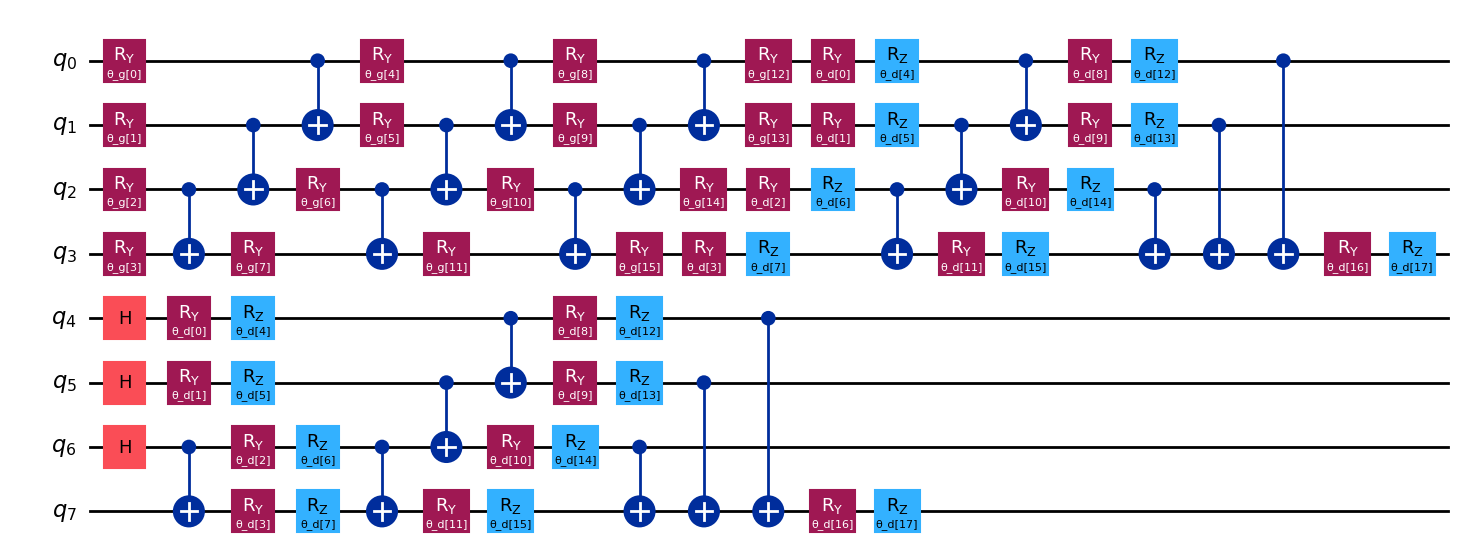

In [11]:
real_disc_circuit = QuantumCircuit(N_QUBITS)
real_disc_circuit.compose(real_circuit, inplace=True)
real_disc_circuit.compose(discriminator, inplace=True)

# Connect generator and discriminator
gen_disc_circuit = QuantumCircuit(N_QUBITS)
gen_disc_circuit.compose(generator.decompose(), inplace=True)
gen_disc_circuit.compose(discriminator, inplace=True)

# Use EstimatorQNN to compile the circuit and handle gradient calculation
estimator = StatevectorEstimator()

gradient = ParamShiftEstimatorGradient(estimator=estimator)

H1 = SparsePauliOp.from_list([("Z" + "I"*(N_QUBITS-1), 1.0)])

H21 = SparsePauliOp.from_list([("Z" + "I"*(2*N_QUBITS-1), 1.0)])
H22 = SparsePauliOp.from_list([(("I"*(N_QUBITS) + "Z" + "I"*(N_QUBITS-1)), 1.0)])

# specify QNN to update generator parameters
gen_qnn = EstimatorQNN(circuit=gen_disc_circuit,
                    input_params=gen_disc_circuit.parameters[:N_DPARAMS], # fixed parameters (discriminator parameters)
                    weight_params=gen_disc_circuit.parameters[N_DPARAMS:], # parameters to update (generator parameters)
                    estimator=estimator,
                    observables=[H1],
                    gradient=gradient,
                    default_precision=0.0
                    )

real_gen_disc_circuit = QuantumCircuit(N_QUBITS*2)
real_gen_disc_circuit.compose(gen_disc_circuit, qubits=range(0,N_QUBITS), inplace=True)
real_gen_disc_circuit.compose(real_disc_circuit, qubits=range(N_QUBITS,(N_QUBITS*2)), inplace=True)

# join both discriminator QNNs in one model
disc_qnn = EstimatorQNN(circuit=real_gen_disc_circuit,
                        input_params=gen_disc_circuit.parameters[N_DPARAMS:],
                        weight_params=gen_disc_circuit.parameters[:N_DPARAMS], # parameters to update (discriminator parameters)
                        estimator=estimator,
                        observables=[H21, H22],
                        gradient=gradient,
                        default_precision=0.0
                        )

real_gen_disc_circuit.draw('mpl')
    

In [12]:
# Initialize Adam optimizer from Keras (TensorFlow)
def generate_optimizers(reset, optimizers_data_folder, gen_qnn, disc_qnn, gen_params, disc_params):

    model_g = TorchConnector(gen_qnn, initial_weights=gen_params.detach().numpy())
    model_d = TorchConnector(disc_qnn, initial_weights=disc_params.detach().numpy())

    optimizer_g = torch.optim.Adam(model_g.parameters(), lr=0.005)
    optimizer_d = torch.optim.Adam(model_d.parameters(), lr=0.005)

    # set model to training mode
    model_g.train() 
    model_d.train()

    #f_loss = torch.nn.KLDivLoss() no, solo pa distribuciones (no guesses)
    f_loss = torch.nn.MSELoss()

    def closure_g():
        optimizer_g.zero_grad()  # Initialize/clear gradients
        disc_params = optimizer_d.param_groups[0]['params'][0]
        loss = f_loss(model_g(torch.tensor(disc_params)), torch.tensor([[1.0]])) # 1-> Good guess
        loss.backward()  # Backward pass
        return loss

    def closure_d():
        optimizer_d.zero_grad()
        gen_params = optimizer_g.param_groups[0]['params'][0]
        results = model_d(gen_params)
        loss_f = f_loss(results[0], torch.tensor([[1.0]]))
        loss_r = f_loss(results[1], torch.tensor([[0.0]]))
        loss = loss_r + loss_f
        loss.backward()
        return loss


    # Create optimizer training state checkpoints
    if reset == 1:
        torch.save(optimizer_g.state_dict(), optimizers_data_folder + 'generator_optimizer.pth')
        torch.save(optimizer_d.state_dict(), optimizers_data_folder + 'discriminator_optimizer.pth')
    else:
        optimizer_g.load_state_dict(torch.load(optimizers_data_folder + 'generator_optimizer.pth'))
        optimizer_d.load_state_dict(torch.load(optimizers_data_folder + 'discriminator_optimizer.pth'))

    return optimizer_g, closure_g, optimizer_d, closure_d
    


In [13]:
# init_gen_params = np.random.uniform(low=-np.pi, high=np.pi, size=(N_GPARAMS,))
# init_disc_params = np.random.uniform(low=-np.pi, high=np.pi, size=(N_DPARAMS,))
# init_disc_params2 = np.tile(init_disc_params, 2)
# gen_params = torch.tensor(init_gen_params, requires_grad=True)
# disc_params = torch.tensor(init_disc_params, requires_grad=True)

# model_g = TorchConnector(gen_qnn, initial_weights=init_gen_params)
# model_d = TorchConnector(disc_qnn, initial_weights=init_disc_params)

# optimizer_g = torch.optim.Adam(model_g.parameters(), lr=0.005)
# optimizer_d = torch.optim.Adam(model_d.parameters(), lr=0.005)

# # set model to training mode
# model_g.train() 
# model_d.train()

# #f_loss = torch.nn.KLDivLoss() no, solo pa distribuciones (no guesses)
# f_loss = torch.nn.MSELoss()

# def closure_g():
#     optimizer_g.zero_grad()  # Initialize/clear gradients
#     loss = f_loss(model_g(disc_params), torch.Tensor([[1.0]])) # 1-> Good guess
#     loss.backward()  # Backward pass
#     return loss

# def closure_d():
#     optimizer_d.zero_grad()
#     results = model_d(gen_params)
#     loss_f = f_loss(results[0], torch.Tensor([[1.0]]))
#     loss_r = f_loss(results[1], torch.Tensor([[0.0]]))
#     loss = loss_r + loss_f
#     loss.backward()
#     return loss


In [14]:
# Performance measurement function: uses Kullback Leibler Divergence to measures the distance between two distributions
def calculate_kl_div(model_distribution: dict, target_distribution: dict):
    kl_div = 0
    for bitstring, p_data in target_distribution.items():
        if np.isclose(p_data, 0, atol=1e-8):
            continue
        if bitstring in model_distribution.keys():
            kl_div += (p_data * np.log(p_data)
                 - p_data * np.log(model_distribution[bitstring]))
        else:
            kl_div += p_data * np.log(p_data) - p_data * np.log(1e-6)
    return kl_div

In [15]:
def manage_files(data_folder_name="data", implementation_name="fullyq_torchc", execution="sim", training_data_file_name='training_data', parameter_data_file_name='parameters', optimizers_data_folder_name='optimizer'):
    data_folder = data_folder_name + '/' + implementation_name + '/' + execution + '/' + 'q' + str(N_QUBITS) + '/' + 'seed' + str(SEED) + '/' 
    training_data_file = data_folder + training_data_file_name + '.txt'
    parameter_data_file = data_folder + parameter_data_file_name + '.txt'
    optimizers_data_folder = data_folder + optimizers_data_folder_name + '/'

    # Create folders if they do not exist
    if not os.path.exists(optimizers_data_folder):
        os.makedirs(optimizers_data_folder)

    return training_data_file, parameter_data_file, optimizers_data_folder
    

In [16]:
def initialize_parameters(reset, training_data_file, parameter_data_file):
    if reset == 1:
        current_epoch = 0
        gloss, dloss, kl_div = [], [], []

        np.random.seed(SEED)
        init_gen_params = np.random.uniform(low=-np.pi, high=np.pi, size=(N_GPARAMS,))
        init_disc_params = np.random.uniform(low=-np.pi, high=np.pi, size=(N_DPARAMS,))
        gen_params = torch.tensor(init_gen_params, requires_grad=True)
        disc_params = torch.tensor(init_disc_params, requires_grad=True)
        best_gen_params = torch.tensor(init_gen_params, requires_grad=True)

        # Reset data files
        with open(training_data_file, 'w') as file:
            pass
        with open(parameter_data_file, 'w') as file:
            file.write(str(gen_params.detach().numpy().tolist()) + ";" + str(disc_params.detach().numpy().tolist()) + ";" + str(gen_params.detach().numpy().tolist()) + ";" + str(disc_params.detach().numpy().tolist()) + ";" + str(best_gen_params.detach().numpy().tolist()) + "\n")
            
    else:
        # Load training data
        try:
            with open(training_data_file) as f:
                lines = f.read().splitlines()
        except FileNotFoundError:
            print("Training data file not found. Resetting parameters.")
            return initialize_parameters(1, training_data_file, parameter_data_file)
        current_epoch = len(lines)
        gloss, dloss, kl_div = [], [], []
        for line in lines:
            line_data = line.split(";")
            if len(line_data) != 4:
                raise Exception("ERROR: Wrong data length in training_data.txt file in line:", line, ". Please, reset data.")
            gloss.append(np.float64(line_data[1]))
            dloss.append(np.float64(line_data[2]))
            kl_div.append(np.float64(line_data[3]))

        # Load parameters
        with open(parameter_data_file) as f: # Load parameters
            line = f.readline()
        line_data = line.split(";")
        if len(line_data) != 5:
            raise Exception("ERROR: Wrong number of parameters in parameters.txt file. Please, reset data.")
        init_gen_params = np.array(eval(line_data[0])).astype(float)
        init_disc_params = np.array(eval(line_data[1])).astype(float)
        gen_params = torch.tensor(np.array(eval(line_data[2])).astype(float), requires_grad=True)
        disc_params = torch.tensor(np.array(eval(line_data[3])).astype(float), requires_grad=True)
        best_gen_params = torch.tensor(np.array(eval(line_data[4])).astype(float), requires_grad=True)

    return current_epoch, gloss, dloss, kl_div, init_gen_params, init_disc_params, gen_params, disc_params, best_gen_params

In [17]:
# from qiskit_machine_learning.connectors import TorchConnector

# model_g = TorchConnector(gen_qnn, initial_weights=gen_params)

# optimizer_g = torch.optim.Adam([gen_params], lr=0.005)
# #f_loss = torch.nn.KLDivLoss() no, solo pa distribuciones (no guesses)
# f_loss = torch.nn.MSELoss()

# model_g.train()  # set model to training mode

# def closure_g():
#     optimizer_g.zero_grad()  # Initialize/clear gradients
#     loss = f_loss(model_g(disc_params), torch.Tensor([[1.0]])) # 1-> Good guess
#     loss.backward()  # Backward pass
#     print(loss.item())  # Print loss
#     return loss


# # Run optimizer step4
# optimizer_g.step(closure_g)

In [18]:
# model_dr = TorchConnector(disc_real_qnn, initial_weights=disc_params)
# model_df = TorchConnector(disc_fake_qnn, initial_weights=disc_params)

# optimizer_d = torch.optim.Adam([disc_params], lr=0.005)

# model_dr.train()
# model_df.train()
# torch.Tensor([[0.0]*N_DPARAMS])
# def closure_dr():
#     optimizer_d.zero_grad()
#     loss = f_loss(model_dr(), torch.Tensor([[1.0]]))
#     loss.backward()
#     print(loss.item())
#     return loss

# def closure_df():
#     optimizer_d.zero_grad()
#     loss = f_loss(model_df(gen_params), torch.Tensor([[0.0]]))
#     loss.backward()
#     print(loss.item())
#     return loss

# optimizer_d.step(closure_dr)
# optimizer_d.step(closure_df)

In [21]:
# Training

#--- Initialize parameters ---#
max_epoch = 1000
reset = 1 # Reset data

training_data_file, parameter_data_file, optimizers_data_folder = manage_files()

current_epoch, gloss, dloss, kl_div, init_gen_params, init_disc_params, gen_params, disc_params, best_gen_params = initialize_parameters(reset, training_data_file, parameter_data_file)


#--- Create and load optimizer states ---#
optimizer_g, closure_g, optimizer_d, closure_d = generate_optimizers(reset, optimizers_data_folder, gen_qnn, disc_qnn, gen_params, disc_params)


D_STEPS = 1
G_STEPS = 1
C_STEPS = 1
if print_progress:
    TABLE_HEADERS = "Epoch | Generator cost | Discriminator cost | KL Div. | Best KL Div. | Time |"
    print(TABLE_HEADERS)
file = open(training_data_file,'a')
start_time = time.time()

#--- Training loop ---#
try: # In case of interruption
    for epoch in range(current_epoch, max_epoch+1):

        #--- Quantum discriminator parameter updates ---#
        for disc_train_step in range(D_STEPS):
            # Calculate discriminator gradients and update parameters
            gen_params = optimizer_g.param_groups[0]['params'][0]
            disc_loss = optimizer_d.step(closure_d)

            # Calculate discriminator cost
            dloss.append(disc_loss)

        #--- Quantum generator parameter updates ---#
        for gen_train_step in range(G_STEPS):
            # Calculate generator gradient and update parameters
            disc_params = optimizer_d.param_groups[0]['params'][0]
            gen_loss = optimizer_g.step(closure_g)

            # Save generator cost
            gloss.append(gen_loss)

        #--- Track KL and save best performing generator weights ---#
        gen_checkpoint_circuit = generator.assign_parameters(gen_params.detach().numpy())
        gen_prob_dict = Statevector(gen_checkpoint_circuit).probabilities_dict() # Retrieve probability distribution of generator with current parameters
        
        real_prob_dict = Statevector(real_circuit).probabilities_dict() # Retrieve real data probability distribution
        
        current_kl = calculate_kl_div(gen_prob_dict, real_prob_dict)
        kl_div.append(current_kl)
        if np.min(kl_div) == current_kl:
            best_gen_params = copy.deepcopy(gen_params) # New best

        #--- Save progress in file ---#
        file.write(str(epoch) + ";" + str(gloss[-1]) + ";" + str(dloss[-1]) + ";" + str(kl_div[-1]) + "\n")

        #--- Print progress ---#
        if print_progress and (epoch % 10 == 0):
            for header, val in zip(TABLE_HEADERS.split('|'),
                                (epoch, gloss[-1], dloss[-1], kl_div[-1], np.min(kl_div), (time.time() - start_time))):
                print(f"{val:.3g} ".rjust(len(header)), end="|")
            start_time = time.time()
            print()
            
#--- Save parameters and optimizer states data ---#
finally:
    file.close()
    file = open(parameter_data_file,'w')
    file.write(str(init_gen_params.tolist()) + ";" + str(init_disc_params.tolist()) + ";" + str(gen_params.detach().numpy().tolist()) + ";" + str(disc_params.detach().numpy().tolist()) + ";" + str(best_gen_params.detach().numpy().tolist()) + "\n")
    file.close()

    torch.save(optimizer_g.state_dict(), optimizers_data_folder + 'generator_optimizer.pth')
    torch.save(optimizer_d.state_dict(), optimizers_data_folder + 'discriminator_optimizer.pth')
    
print("Training complete:", training_data_file, "Results:", np.min(kl_div), "Improvement:", kl_div[0]-np.min(kl_div))


Epoch | Generator cost | Discriminator cost | KL Div. | Best KL Div. | Time |


/tmp/ipykernel_4904/2028484198.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = f_loss(model_g(torch.tensor(disc_params)), torch.tensor([[1.0]])) # 1-> Good guess


    0 |           1.74 |              0.748 |    3.46 |         3.46 | 0.58 |
   10 |           1.39 |              0.496 |    2.79 |         2.79 | 5.78 |
   20 |           1.16 |              0.322 |    2.43 |         2.43 | 5.59 |
   30 |           1.01 |              0.209 |    2.26 |         2.26 | 5.58 |
   40 |          0.906 |               0.14 |    2.22 |         2.22 | 5.63 |
   50 |          0.842 |             0.0978 |    2.33 |         2.22 | 5.55 |
   60 |          0.788 |             0.0748 |    2.71 |         2.22 | 5.54 |
   70 |          0.724 |             0.0669 |    3.76 |         2.22 | 5.71 |
   80 |          0.644 |             0.0732 |    2.73 |         2.22 | 6.44 |
   90 |          0.552 |             0.0946 |    2.92 |         2.22 | 6.85 |
  100 |          0.451 |              0.134 |    3.04 |         2.22 | 6.35 |
  110 |          0.355 |              0.189 |    2.34 |         2.22 | 6.51 |
  120 |          0.281 |              0.248 |    2.16 |         

KeyboardInterrupt: 

In [ ]:
draw_results = 1
if draw_results:
        def prepare_loss_data(l): # For when C_STEPS > 1, implemented for creating less jobs in real hardware
                ax = [0]
                data =  [l[0]]
                for i in range(1, len(l)):
                        if l[i] != l[i - 1]:
                                ax.append(i)
                                data.append(l[i])
                return ax, data

        # Load saved data
        training_data_file, parameter_data_file, optimizers_data_folder = manage_files()
        current_epoch, gloss, dloss, kl_div, init_gen_params, init_disc_params, gen_params, disc_params, best_gen_params = initialize_parameters(0, training_data_file, parameter_data_file)

        gloss_ax, gloss_data = prepare_loss_data(gloss)
        dloss_ax, dloss_data = prepare_loss_data(dloss)

        fig, (loss, kl) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [0.75, 1]}, figsize=(6,4))
        '''fig.set_facecolor("#135077ff")
        fig.set_edgecolor("#ffffffff")
        loss.set_facecolor("#135077ff")
        loss.spines['bottom'].set_color("#ffffffff")
        loss.spines['top'].set_color("#ffffffff") 
        loss.spines['right'].set_color("#ffffffff")
        loss.spines['left'].set_color("#ffffffff")

        loss.tick_params(axis='x', colors="#ffffffff")
        loss.tick_params(axis='y', colors="#ffffffff")

        loss.yaxis.label.set_color("#ffffffff")
        loss.xaxis.label.set_color("#ffffffff")
        loss.title.set_color("#ffffffff")
        kl.set_facecolor("#135077ff")
        kl.spines['bottom'].set_color("#ffffffff")
        kl.spines['top'].set_color("#ffffffff") 
        kl.spines['right'].set_color("#ffffffff")
        kl.spines['left'].set_color("#ffffffff")

        kl.tick_params(axis='x', colors="#ffffffff")
        kl.tick_params(axis='y', colors="#ffffffff")

        kl.yaxis.label.set_color("#ffffffff")
        kl.xaxis.label.set_color("#ffffffff")
        kl.title.set_color("#ffffffff")'''
        fig.suptitle('QGAN training stats', color="#ffffffff")
        kl.set_xlabel("Epochs", color="#ffffffff")
        loss.plot(gloss_ax, gloss_data, label="Generator loss", color="#0094f0ff")
        loss.plot(dloss_ax, dloss_data, label="Discriminator loss", color="C3")
        loss.legend()
        loss.set(ylabel='Loss')
        kl.plot(range(len(kl_div)), kl_div, label="KL Divergence (zero is best)", color="#ffaf01ff")
        kl.set(ylabel='KL Divergence')
        kl.legend()
        fig.tight_layout()

        print("Training complete:", training_data_file, "Results:", np.min(kl_div), "Improvement:", kl_div[0]-np.min(kl_div), np.argmin(kl_div))

ValueError: could not convert string to float: 'tensor(1.7440, grad_fn=<MseLossBackward0>)'

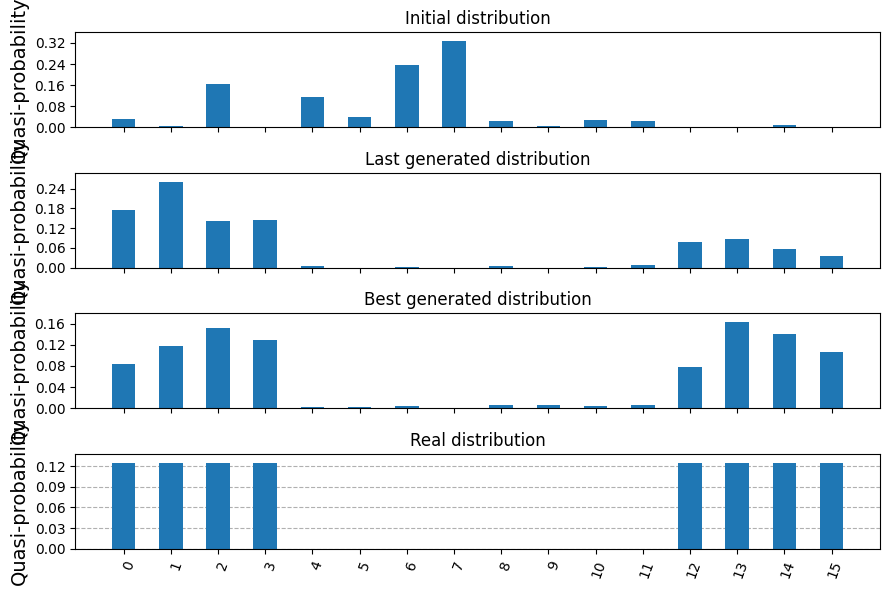

In [ ]:
# Create test circuit with new parameters
draw_results = 1
if draw_results:
    dict1 = Statevector(generator.assign_parameters(init_gen_params)).probabilities_dict()
    dict2 = Statevector(generator.assign_parameters(gen_params.detach().numpy())).probabilities_dict()
    dict3 = Statevector(generator.assign_parameters(best_gen_params.detach().numpy())).probabilities_dict()
    dict4 = Statevector(real_circuit).probabilities_dict()
    
    def prepare_dicts(dicts):
        for dict in dicts:
            for n in range(2**N_QUBITS):
                key = format(n, 'b').zfill(N_QUBITS)
                if key not in dict.keys():
                    dict[n] = 0.0
                else:
                    dict[n] = dict[key]
                    del dict[key]
        

    prepare_dicts([dict1, dict2, dict3, dict4])

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharey=False, sharex=True, figsize=(9,6))
    '''fig.set_facecolor("#135077ff")
    fig.set_edgecolor("#ffffffff")
    ax1.set_facecolor("#135077ff")
    ax1.spines['bottom'].set_color("#ffffffff")
    ax1.spines['top'].set_color("#ffffffff") 
    ax1.spines['right'].set_color("#ffffffff")
    ax1.spines['left'].set_color("#ffffffff")

    ax1.tick_params(axis='x', colors="#ffffffff")
    ax1.tick_params(axis='y', colors="#ffffffff")

    ax1.yaxis.label.set_color("#ffffffff")
    ax1.xaxis.label.set_color("#ffffffff")
    ax1.title.set_color("#ffffffff")

    ax2.set_facecolor("#135077ff")
    ax2.spines['bottom'].set_color("#ffffffff")
    ax2.spines['top'].set_color("#ffffffff") 
    ax2.spines['right'].set_color("#ffffffff")
    ax2.spines['left'].set_color("#ffffffff")

    ax2.tick_params(axis='x', colors="#ffffffff")
    ax2.tick_params(axis='y', colors="#ffffffff")

    ax2.yaxis.label.set_color("#ffffffff")
    ax2.xaxis.label.set_color("#ffffffff")
    ax2.title.set_color("#ffffffff")

    ax3.set_facecolor("#135077ff")
    ax3.spines['bottom'].set_color("#ffffffff")
    ax3.spines['top'].set_color("#ffffffff") 
    ax3.spines['right'].set_color("#ffffffff")
    ax3.spines['left'].set_color("#ffffffff")

    ax3.tick_params(axis='x', colors="#ffffffff")
    ax3.tick_params(axis='y', colors="#ffffffff")

    ax3.yaxis.label.set_color("#ffffffff")
    ax3.xaxis.label.set_color("#ffffffff")
    ax3.title.set_color("#ffffffff")

    ax4.set_facecolor("#135077ff")
    ax4.spines['bottom'].set_color("#ffffffff")
    ax4.spines['top'].set_color("#ffffffff") 
    ax4.spines['right'].set_color("#ffffffff")
    ax4.spines['left'].set_color("#ffffffff")

    ax4.tick_params(axis='x', colors="#ffffffff")
    ax4.tick_params(axis='y', colors="#ffffffff")

    ax4.yaxis.label.set_color("#ffffffff")
    ax4.xaxis.label.set_color("#ffffffff")
    ax4.title.set_color("#ffffffff")

    ax4.set_xlabel("States", color="#ffffffff")
    ax4.set_ylabel("Probabilities", color="#ffffffff")'''
    
    ax1.set_ylabel('Probabilities')
    ax1.set_title("Initial distribution")
    ax2.set_title("Last generated distribution")
    ax3.set_title("Best generated distribution")
    ax4.set_title("Real distribution")
    plot_histogram(dict1, ax=ax1, bar_labels=False)
    plot_histogram(dict2, ax=ax2, bar_labels=False)
    plot_histogram(dict3, ax=ax3, bar_labels=False)
    plot_histogram(dict4, ax=ax4, bar_labels=False)
    fig.tight_layout()